<a href="https://colab.research.google.com/github/yonitsur/ML-workshop/blob/main/notebooks/Final_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2
import yaml
import sys
import os
from IPython import display
import time
from google.colab import drive
import torch
import torch.nn as nn
from PIL import Image

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
from segment_anything.utils.amg import *
from pycocotools import mask as mask_utils

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-uutfb1mc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-uutfb1mc
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [ ]:
folder_path = "/content/drive/MyDrive/Project/Project/data"
project_path = "/content/drive/MyDrive/Project/Project/"
# folder_path = "/content/drive/MyDrive/Project/data"
# project_path = "/content/drive/MyDrive/Project/"

In [ ]:
labels_dict = { 'Metal':0,
              'Metal (general)': 0,
              'Metal (iron bender)':0,
              'Metal (pipe)':0,
              'Wood (pallett)':1,
              'Wood (scraps/cuttings)':1,
              'Wood':1,
              'Paper':2,
              'Carton':2,
              'Nylon':3,
              'Plastic (big bag)':3,
              'Plastic (bucket)':3,
              'Plastic (general)':3,
              'Plastic (pipe)':3,
              'Plastic (sand bag)':3,
              'Plastic':3,
              'Polymers':3,
              'Flexible polymers':3,
              'Rigid polymers':3,
              'Gypsum':4,
              'Concrete':4,
              'Ceramics':4,
              'Rubber':5,
              'Background':6,

              #others
              'Styrofoam':7,
              'Textil':7,
              'Textil/Fabric/Cloth':7,
              'Glass':7,
              'Other(Styrofoam, Textil, Glass)':7
              }

reverse_labels_dict = {0:'Metal',
                1:'Wood',
               2:'Carton+Paper',
               3:'Polymers',
               4:'Mineral',
                5:'Rubber',

               6:'Background',
              7:'Other(Styrofoam, Textil, Glass)'
                       }

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import json

with open(f'{project_path}/jsons/annotations.json') as f:
  json_dict1 = json.load(f)


In [ ]:
with open(f'{project_path}/jsons/segs.json') as f:
  seg = json.load(f)

In [ ]:
NORMALIZE = True

In [ ]:
sizes = {}

In [ ]:
def imshow(inp, t=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    if NORMALIZE:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    # ax.figure(figsize=(5,5))
    plt.imshow(inp)
    if t is not None:
        plt.title(t)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
class SplitDatasetMaskedResized(Dataset):
  def __init__(self, path, owner, image_name, sp, rotation=0, flip=None, color_aug=False, local=False):
    self.image_name = image_name
    self.sp = sp
    self.local = local
    self.folder_path = path
    self.owner = owner
    self.seg=seg
    self.rotation=rotation
    self.flip = flip
    self.color_aug = color_aug
    self.im_path = f'{self.folder_path}/{owner}/{image_name}'
    self.split_path = f'{self.im_path}/split_{sp}'
    # with open(f'{self.split_path}/seg_{sp}.yaml') as f:
    #   self.seg = yaml.safe_load(f)
    files_in_folder = os.listdir(self.split_path)
    self.ann_dict={image_name:{sp:{}}}
    if f'anns_{sp}.yaml' in files_in_folder:
      with open(f'{self.split_path}/anns_{sp}.yaml', 'r') as f:
        self.ann_dict = yaml.safe_load(f)
        # print(self.ann_dict)
        # if len(self.ann_dict[self.image_name][self.sp]) == 0:
        #   self.ann_dict.update(json_dict1)
        # elif self.image_name in json_dict1:
        #   for mask in json_dict1[self.image_name][self.sp]:
        #     if mask in self.ann_dict[self.image_name][self.sp]:
        #       if self.ann_dict[self.image_name][self.sp][mask]!=json_dict1[self.image_name][self.sp][mask]:
        #         print(self.image_name, self.sp, mask)
        #     else:
        #       self.ann_dict[self.image_name][self.sp][mask] = json_dict1[self.image_name][self.sp][mask]
        #print(self.image_name, self.sp)
        # Remove all unknowns
    if self.image_name in json_dict1 and self.sp in json_dict1[self.image_name]:
      self.ann_dict[self.image_name][self.sp].update(json_dict1[self.image_name][self.sp])

    # discarded = len([a for a in self.ann_dict[self.image_name][self.sp].values() if a in ['Paper', 'Rubber', 'Glass']])
    # self.others = discarded

    self.ann_dict[self.image_name][self.sp] = {key:val for key, val in self.ann_dict[self.image_name][self.sp].items()
      if val in labels_dict.keys() and key in self.seg[image_name][f'split_{sp}'] and self.seg[image_name][f'split_{sp}'][key]['area'] > 2000}
        # TODO: eliminate masks that are too small


  def __len__(self):
    return len(self.ann_dict[self.image_name][self.sp])

  def __getitem__(self, idx):
    annotated_masks = list(self.ann_dict[self.image_name][self.sp].keys())
    # self.sizes = np.zeros((len(annotated_masks),2))
    m = annotated_masks[idx]
    if not self.local:
      fp = folder_path # Take care of differences when working on colab vs locally
    else:
      fp = folder_path
    img = cv2.imread(f'{fp}/{self.owner}/{self.image_name}/split_{self.sp}/{m}.jpg')
    # print(self.image_name, self.sp, m)
    # feat = get_texture_features(img)
    # mean = feat.mean(1)
    # std = feat.std(1)
    # feat = (feat - mean)/std
    # with open(f'{self.split_path}/seg_{self.sp}.yaml') as f:
    #   self.seg = yaml.safe_load(f)
    # self.seg
    feat = torch.Tensor(self.seg[self.image_name][f'split_{self.sp}'][m]['textures'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    im_pil = Image.fromarray(img)


    if self.rotation != 0:
      im_pil = im_pil.rotate(self.rotation, Image.NEAREST, expand=1)
      # image = im_pil
      # image_array = np.array(image)
      # lower_threshold = np.array([20, 20, 20])  # Minimum color values
      # upper_threshold = np.array([255, 255, 255])  # Maximum color values
      # binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
      # object_pixels = np.where(binary_mask)

      # min_y, min_x = np.min(object_pixels, axis=1)
      # max_y, max_x = np.max(object_pixels, axis=1)
      # im_pil=im_pil.crop((min_x,min_y,max_x,max_y))

    if self.flip != None:
      if self.flip == "h":
        im_pil = im_pil.transpose(Image.FLIP_LEFT_RIGHT)
      elif self.flip == "v":
        im_pil = im_pil.transpose(Image.FLIP_TOP_BOTTOM)

    if (self.seg[self.image_name][f'split_{self.sp}'][m]['area']/(im_pil.size[0]*im_pil.size[1]))<0.4:
      best_coverage = 0
      best_img = im_pil
      for _ in [15,30,45,60,75,90]:
        im_pil = im_pil.rotate(_, Image.NEAREST, expand=1)
        image = im_pil
        image_array = np.array(image)
        lower_threshold = np.array([20, 20, 20])  # Minimum color values
        upper_threshold = np.array([255, 255, 255])  # Maximum color values
        binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
        object_pixels = np.where(binary_mask)

        min_y, min_x = np.min(object_pixels, axis=1)
        max_y, max_x = np.max(object_pixels, axis=1)
        coverage = np.sum(binary_mask)/((max_x-min_x)*(max_y-min_y))

        # print(_, coverage)
        # bbox_image = Image.fromarray(image_array[min_y:max_y+1, min_x:max_x+1])
        # bbox_image.save("bounding_box.png")
        # bbox_image.show()

        # Bounding box coordinates
        im_pil=im_pil.crop((min_x,min_y,max_x,max_y))
        if(coverage>best_coverage):
          best_coverage = coverage
          best_img = im_pil
        im_pil = im_pil.rotate(-_, Image.NEAREST, expand=1)

      im_pil = best_img

    sizes[str(feat.detach())] = self.owner, self.image_name, self.sp, m, im_pil.size

    preprocess0 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor()
    ])
    preprocess1 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    preprocess2 = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.02, hue=0.02),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    # input_tensor = preprocess(im_pil)
    if NORMALIZE:
        if self.color_aug:
          input_tensor = preprocess2(im_pil)
        else:
          input_tensor = preprocess1(im_pil)
    else:
        input_tensor = preprocess0(im_pil)

    # mask = rle_to_mask(self.seg[self.image_name][self.sp][m]['segmentation'])
    label = self.ann_dict[self.image_name][self.sp][m]
    y = labels_dict[label]
    return input_tensor, feat, y

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Best available weights (currently alias for IMAGENET1K_V2)
# Note that these weights may change across versions
original_model = resnet50(weights=ResNet50_Weights.DEFAULT)

In [ ]:
import copy
import seaborn as sns

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, test=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 9999
    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        confusion_matrix = torch.zeros(len(reverse_labels_dict), len(reverse_labels_dict))
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train' and test:
                continue
            if phase == 'train' and not test:
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            if phase == 'val' and test:
                phase = 'test'
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for imgs, features, labels in dataloaders[phase]:
                # print(inputs, labels)
                imgs = imgs.cuda()
                features = features.cuda()
                labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model((imgs, features))
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * imgs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'val' or phase == 'test':
                    for t, p in zip(labels.view(-1), preds.view(-1)):
                        confusion_matrix[t.long(), p.long()] += 1

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_acc.append(epoch_acc.item())
                # print(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                test_acc.append(epoch_acc.item())
                test_loss.append(epoch_loss)


            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                group_counts = ["{0: 0.0f}".format(value) for value in confusion_matrix.flatten()]
                labels = [f"{v1}" for v1 in group_counts]
                labels = np.asarray(labels).reshape(len(reverse_labels_dict), len(reverse_labels_dict))
                sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
                            xticklabels=reverse_labels_dict.values(), yticklabels=reverse_labels_dict.values())
                plt.show()

            if test and phase == 'test':
                group_counts = ["{0: 0.0f}".format(value) for value in confusion_matrix.flatten()]
                labels = [f"{v1}" for v1 in group_counts]
                labels = np.asarray(labels).reshape(len(reverse_labels_dict), len(reverse_labels_dict))
                sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues',
                            xticklabels=reverse_labels_dict.values(), yticklabels=reverse_labels_dict.values())
                plt.show()

                per_class_amount = list(confusion_matrix.sum(1).numpy())
                per_class_recall = list((confusion_matrix.diag()/confusion_matrix.sum(1)).numpy())
                per_class_precision = list((confusion_matrix.diag()/confusion_matrix.sum(0)).numpy())
                per_class_f1 = list([(2*per_class_precision[i]*per_class_recall[i]/(per_class_precision[i]+per_class_recall[i])).item()
                                for i in range(len(per_class_recall))])
                return per_class_amount, per_class_precision, per_class_recall, per_class_f1
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, (train_acc, train_loss, test_acc, test_loss)

In [ ]:
class Altered(nn.Module):
    def __init__(self):
        super(Altered, self).__init__()
        for param in original_model.parameters():
            param.requires_grad = False
        num_ftrs = original_model.fc.in_features
        original_model.fc = nn.Linear(num_ftrs, 256)
        self.resnet = original_model#.cuda()
        self.relu = nn.ReLU(inplace=True)
        self.fc_1 = nn.Linear(256, len(reverse_labels_dict))#.cuda()
        # self.fc_2 = nn.Linear(24, len(reverse_labels_dict)).cuda()
        # self.seq = nn.Sequential(self.fc1, nn.ReLU(), self.fc2, nn.ReLU(), self.fc3)

    def forward(self, x):
        im, feat = x
        # feat = feat.cuda()
        out = self.resnet(im)
        out = self.relu(out)
        out1 = self.fc_1(out)

        # feat = feat.float()
        # feat = feat.reshape(-1, 24)
        # out2 = self.fc_2(feat)

        out = out1 #+ out2
        return out

In [ ]:
model = Altered()

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
# model_conv = torchvision.models.resnet18(weights='DEFAULT')
# for param in original_model.parameters():
#     param.requires_grad = False

# # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = original_model.fc.in_features
# net = nn.Sequential(nn.ReLU(inplace=True), nn.Linear(256, 14))
# original_model.fc = nn.Linear(num_ftrs, 256)
# model = nn.Sequential(original_model, net)

# model = original_model
# print(model[0].fc, model[1][1])
criterion = nn.CrossEntropyLoss() #reweight the loss such that each class has equal contribution to the loss

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD([{'params': model.resnet.fc.parameters()},
                {'params': model.fc_1.parameters()}], lr=0.002, momentum=0.9)

# Decay LR by a factor of 0.1 every 15 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=10, gamma=0.5)

In [ ]:
model_transfered = model
model_transfered.load_state_dict(torch.load(f"{project_path}/models/transfered_basic_resnet50_22", map_location=torch.device('cpu') ))

<All keys matched successfully>

In [ ]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for x in dataloaders['val']:
#             inputs = x[0].cuda()
#             features = x[1].cuda()
#             labels=x[-1].cuda()

#             outputs = model((inputs, features))
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 plt.figure(figsize=(5,5))

#                 ax.axis('off')
#                 ax.set_title(f'predicted: {reverse_labels_dict[preds[j].item()]}, actual: {reverse_labels_dict[labels[j].item()]}')
#                 # print(ax)
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [ ]:
# visualize_model(model_transfered, num_images=20)
# # plt.legend()
# plt.ioff()
# plt.show()

In [ ]:
def get_wrong_cases(model, dataset):
  model.eval()
  num_right = 0
  for x in dataset:
    inputs = x[0].cuda()
    features = x[1].cuda()
    labels=x[-1].cuda()

    outputs = model((inputs, features))

    _, preds = torch.max(outputs, 1)
    preds= preds.cpu()
    labels = labels.cpu()

    num_right += len(np.where(preds == labels))
    # wrong_indices = np.where(preds != labels)
    # wrong_inputs = inputs[wrong_indices]
    # wrong_features = features[wrong_indices]
    # wrong_labels = labels[wrong_indices]
    #return wrong_inputs, wrong_features, wrong_labels
    # return inputs, features,labels
  return num_right

In [ ]:
def process_mask(image_name, sp, mask):
  mask_im = cv2.imread(f'{folder_path}/Adi/{image_name}/split_{sp}/{mask}.jpg')
  # feat = torch.Tensor(seg[self.image_name][f'split_{self.sp}'][m]['textures'])
  img = cv2.cvtColor(mask_im, cv2.COLOR_BGR2RGB)
  im_pil = Image.fromarray(img)

  if (seg[image_name][f'split_{sp}'][mask]['area']/(im_pil.size[0]*im_pil.size[1]))<0.4:
    best_coverage = 0
    best_img = im_pil
    for _ in [15,30,45,60,75,90]:
      im_pil = im_pil.rotate(_, Image.NEAREST, expand=1)
      image = im_pil
      image_array = np.array(image)
      lower_threshold = np.array([20, 20, 20])  # Minimum color values
      upper_threshold = np.array([255, 255, 255])  # Maximum color values
      binary_mask = np.all((image_array >= lower_threshold) & (image_array <= upper_threshold), axis=-1)
      object_pixels = np.where(binary_mask)

      min_y, min_x = np.min(object_pixels, axis=1)
      max_y, max_x = np.max(object_pixels, axis=1)
      coverage = np.sum(binary_mask)/((max_x-min_x)*(max_y-min_y))

      # print(_, coverage)
      # bbox_image = Image.fromarray(image_array[min_y:max_y+1, min_x:max_x+1])
      # bbox_image.save("bounding_box.png")
      # bbox_image.show()

      # Bounding box coordinates
      im_pil=im_pil.crop((min_x,min_y,max_x,max_y))
      if(coverage>best_coverage):
        best_coverage = coverage
        best_img = im_pil
      im_pil = im_pil.rotate(-_, Image.NEAREST, expand=1)

    im_pil = best_img

  preprocess1 = transforms.Compose([
  transforms.Resize((224,224)),
  # transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  # preprocess2 = transforms.Compose([
  # transforms.Resize((224,224)),
  # # transforms.CenterCrop(224),
  # transforms.ToTensor(),
  # transforms.ColorJitter(brightness=0.02, contrast=0.02, saturation=0.02, hue=0.02),
  # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  # ])
  # input_tensor = preprocess(im_pil)
  # if NORMALIZE:
  #     # if self.color_aug:
  #     #   input_tensor = preprocess2(im_pil)
  #     # else:
  input_tensor = preprocess1(im_pil)
  # else:
  #     input_tensor = preprocess0(im_pil)
  return input_tensor

In [ ]:
labels_colors={
    'Metal':(1, 0, 0),
    'Wood':(1, 1, 0),
    'Carton+Paper':(0.5, 0.2, 0),
    'Polymers':(1, 0.63, 0),
    'Mineral':(0.1, 0.1, 0.1),
    'Background':(0, 1, 0),
    'Other(Styrofoam, Textil, Glass)':(0.5, 0, 1),
    'Rubber':(1, 0, 1)
}

def show_anns(anns, predicted):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    #for ann in sorted_anns:
    for ann, label in zip(anns, predicted.values()):
        m = rle_to_mask(ann['segmentation'])
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = labels_colors[label]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.25)))

In [ ]:
from tqdm import tqdm

labels_colors={
    'Metal':(1, 0, 0),
    'Wood':(1, 1, 0),
    'Carton+Paper':(0.5, 0.2, 0),
    'Polymers':(1, 0.63, 0),
    'Mineral':(0.1, 0.1, 0.1),
    'Background':(0, 1, 0),
    'Other(Styrofoam, Textil, Glass)':(0.5, 0, 1),
    'Rubber':(1, 0, 1)
}

def show_anns(anns, predicted, ax):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    # ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    #for ann in sorted_anns:
    for ann, label in zip(anns, predicted.values()):
        m = rle_to_mask(ann['segmentation'])
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = labels_colors[label]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.25)))


def process_image(im_name):
  correct_counter = 0
  total_counter = 0
  for sp in tqdm(range(16)):
        # ... (your code before this)
        predicted = {}
        for m in json_dict1[im_name][f'split_{sp}'].items():
          # print(m)
          m_name, lab = m
          inputs = process_mask(im_name, sp, m_name).unsqueeze(0)
          outputs = model((inputs, torch.Tensor([])))
          _, preds = torch.max(outputs, 1)
          predicted[m_name] = reverse_labels_dict[preds[0].item()]
          # print("Predicted:",reverse_labels_dict[preds[0].item()],"Actual:", lab)
          try:
            if preds[0].item() == labels_dict[lab]:
              correct_counter += 1
            total_counter += 1
          except:
            pass

        img = cv2.imread(f'{folder_path}/Adi/{im_name}/split_{sp}/split_{sp}.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        masks = list(seg[im_name][f'split_{sp}'].values())
        # print(predicted)
        # plt.imshow(img)
        # plt.colorbar(heatmap)
        #show_anns(masks, predicted)
        # Display the image with masks and annotations
        plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

        # plt.subplot(1, 2, 1)
        # plt.imshow(img)
        # show_anns(masks, predicted)
        # plt.axis('off')

        colors = labels_colors
        categories = list(colors.keys())

        values = np.linspace(0, 1, len(categories))
        cmap = plt.cm.colors.ListedColormap([colors[category] for category in categories])
        norm = plt.cm.colors.Normalize(vmin=0, vmax=len(categories)-1)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])  # Dummy array for the ScalarMappable


        spec = plt.GridSpec(1, 2, width_ratios=[15, 1])  # Adjust ratios as needed
        fig = plt.figure(figsize=(12, 6))  # Adjust the figure size as needed

        # Display the image with masks and annotations in the first subplot
        ax1 = fig.add_subplot(spec[0])
        ax1.imshow(img)
        show_anns(masks, predicted, ax1)
        ax1.axis('off')

        # Create a color bar in the second subplot
        ax2 = fig.add_subplot(spec[1])
        color_bar = plt.colorbar(sm, cax=ax2)
        color_bar.set_ticks(np.arange(len(categories)))
        color_bar.set_ticklabels(categories)
        color_bar.set_label('')

        plt.tight_layout()  # Adjust spacing between subplots
        plt.show()



  0%|          | 0/16 [00:00<?, ?it/s]

<Figure size 1200x600 with 0 Axes>

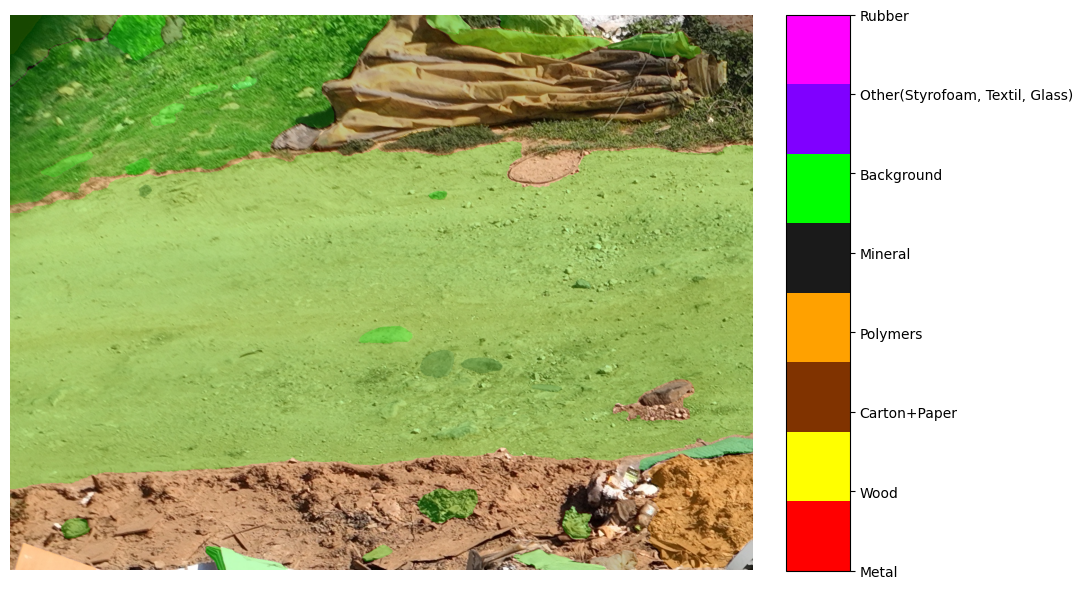

  6%|▋         | 1/16 [00:15<03:57, 15.82s/it]

<Figure size 1200x600 with 0 Axes>

  6%|▋         | 1/16 [00:29<07:15, 29.03s/it]


KeyboardInterrupt: ignored

In [ ]:
# for image in os.listdir(f'{folder_path}/Arik'):
process_image('DJI_20230221095630_0096_V')